# London record temperatures
### Is London's weather becoming more volatile?
##### Huw Hallam


<br>This data visualisation and time series analysis project explores how London's weather is changing. In part 1, I calculate, for each calendar day, the outer range of air temperatures - highest highs and lowest lows - recorded in London during the decade from 2014-2023. I then show how frequently the temperatures recorded for 2024 exceed these outer bounds. In parts 2-3, I then explore whether the findings in part 1 are indicative of a broader trend toward more volatile weather.

#### Source data
##### NOAA National Centers for Environmental Information
Daily summaries for London, UK, accessed from Climate Data Online. https://www.ncdc.noaa.gov/cdo-web/search

<br>© Huw Hallam, 2025

## Part 1 - visualising record temperatures for 2024

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('NOAA - London weather 1975-2024.csv')
#display(df.head())
df.size

347840

##### Data quality checks
Some entries are empty or use default values where data is missing

In [3]:
print("Number of null values for each station in TMAX column:")
print(df.TMAX.isnull().groupby([df.NAME, df.STATION]).sum().astype(int))
print("\nNumber of null values for each station in TMIN column:")
print(df.TMIN.isnull().groupby([df.NAME, df.STATION]).sum().astype(int))

Number of null values for each station in TMAX column:
NAME           STATION    
HAMPSTEAD, UK  UKE00105915      78
HEATHROW, UK   UKE00107650       1
               UKM00003772    5618
WISLEY, UK     UKE00156884      83
Name: TMAX, dtype: int64

Number of null values for each station in TMIN column:
NAME           STATION    
HAMPSTEAD, UK  UKE00105915     115
HEATHROW, UK   UKE00107650       0
               UKM00003772    7647
WISLEY, UK     UKE00156884      86
Name: TMIN, dtype: int64


In [5]:
df.STATION.value_counts()

STATION
UKM00003772    18323
UKE00107650    18294
UKE00156884    17777
UKE00105915    15174
Name: count, dtype: int64

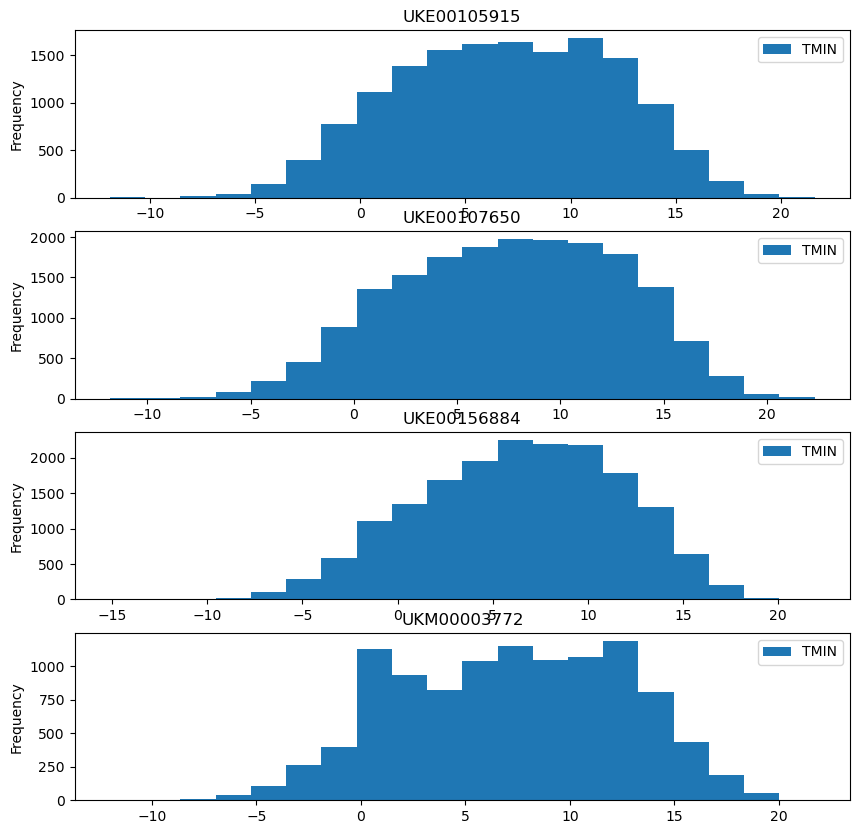

In [7]:
# Create frequency distribution to spot inappropriate use of default values
ax = df.plot.hist(column=['TMIN'], by='STATION', bins=20, figsize=(10,10))


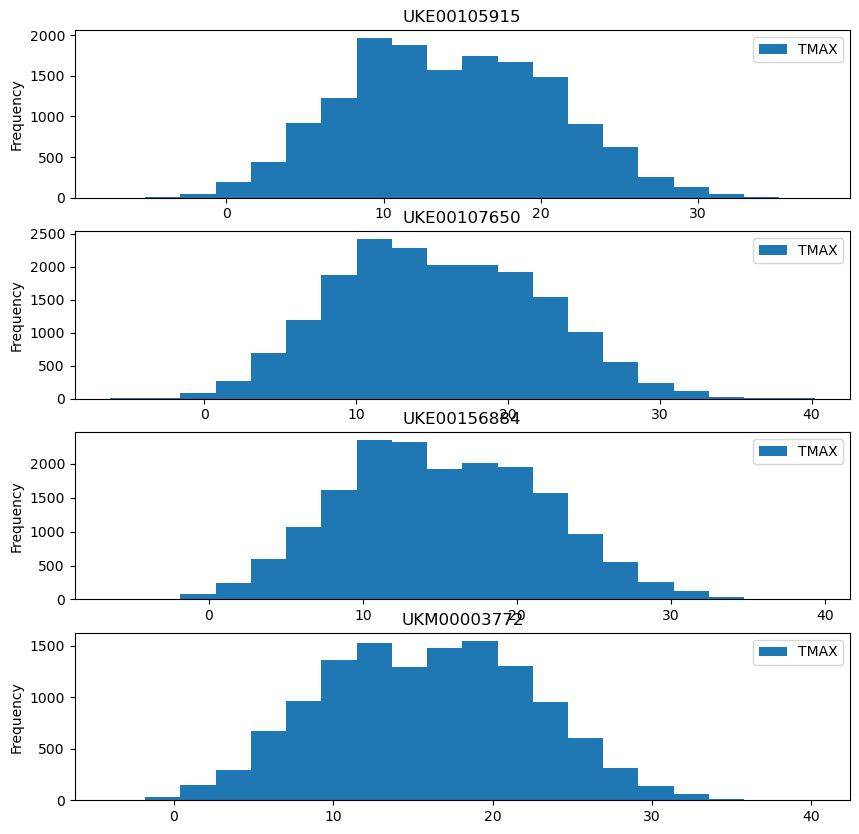

In [8]:
ax = df.plot.hist(column=['TMAX'], by='STATION', bins=20, figsize=(10,10))

In [11]:
df['TMAX'].value_counts()

TMAX
 12.0    578
 11.0    563
 10.0    551
 19.0    525
 18.0    512
        ... 
-4.8       1
-2.7       1
-2.8       1
-5.0       1
 36.4      1
Name: count, Length: 410, dtype: int64

Heathrow station UKM00003772 has a high number of null values and also has an improbable number of 0's recorded for the min temperature (which suggests 0 was sometimes recorded in place of absent data). As such I will exclude it from future calculations.

The TMAX figures have a surprising distribution with two humps, but the mode value is only slightly higher than the next highest; unlike for the TMIN figures, this doesn't point to a default value having been used.

Notes also that Hampstead station has thousands fewer entries than the other stations.

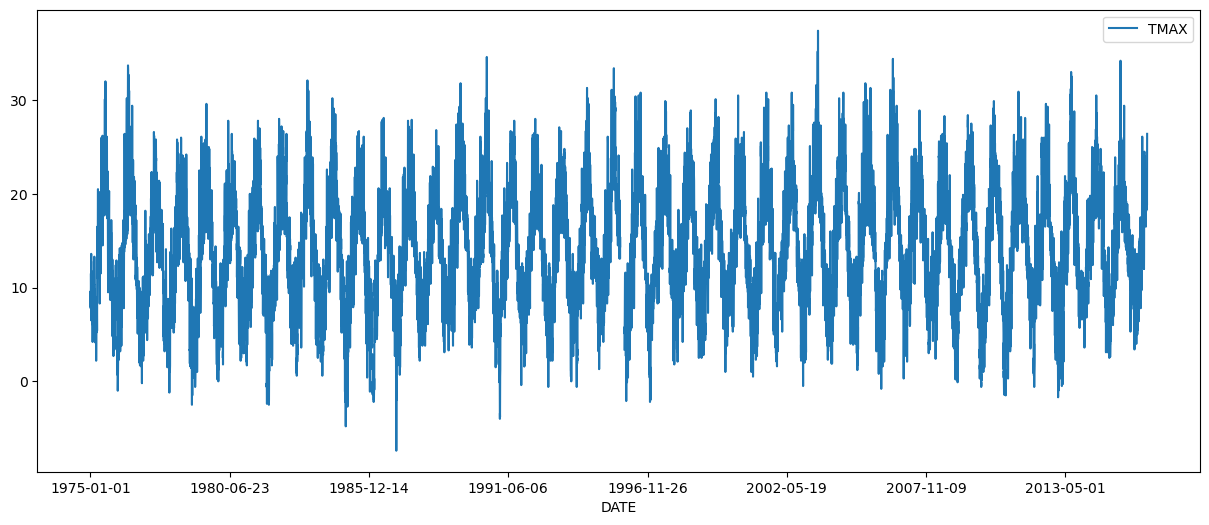

In [13]:
ax = df.loc[df.STATION == 'UKE00105915'].plot(x='DATE', y='TMAX', figsize=(15,6))

In [15]:
print(f"Earliest record for Hampstead: {df.loc[df.STATION == 'UKE00105915', 'DATE'].min()}; latest: {df.loc[df.STATION == 'UKE00105915', 'DATE'].max()}")

Earliest record for Hampstead: 1975-01-01; latest: 2016-07-17


Hampstead station stopped providing data in the summer of 2016.

In [17]:
# Remove data for station UKM00003772
df = df.loc[df.STATION != 'UKM00003772']
# Remove unnecessary columns
df = df[['DATE', 'TMAX', 'TMIN']]

#converte 'DATE' to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

#drop the 29 February
df = df.loc[df['DATE'].dt.strftime('%m-%d') != '02-29']

In [19]:
# Create subsets of minimum and maximum temperatures for the period 2014-2023, grouped by day of year
mins_14_23 = df.loc[df['DATE'].between('2014-01-01', '2023-12-31')].groupby(df['DATE'].dt.strftime('%m-%d'))['TMIN'].min()
maxs_14_23 = df.loc[df['DATE'].between('2014-01-01', '2023-12-31')].groupby(df['DATE'].dt.strftime('%m-%d'))['TMAX'].max()
avg_lows_14_23 = df.loc[df['DATE'].between('2014-01-01', '2023-12-31')].groupby(df['DATE'].dt.strftime('%m-%d'))['TMIN'].mean()
avg_highs_14_23 = df.loc[df['DATE'].between('2014-01-01', '2023-12-31')].groupby(df['DATE'].dt.strftime('%m-%d'))['TMAX'].mean()

# Create subset of mins and maxs for 2024 data grouped by day of year
mins_2024 = df.loc[df['DATE'].between('2024-01-01', '2024-12-31')].groupby(df['DATE'].dt.strftime('%m-%d'))['TMIN'].min()
maxs_2024 = df.loc[df['DATE'].between('2024-01-01', '2024-12-31')].groupby(df['DATE'].dt.strftime('%m-%d'))['TMAX'].max()

# Create collection of 2024 datapoints that exceed previous decades maxima and minima
record_lows = mins_2024.loc[mins_2024 < mins_14_23]
record_highs = maxs_2024.loc[maxs_2024 > maxs_14_23]
records = pd.concat([record_lows, record_highs])
print(f"Numbers of record lows and highs in 2024 compared to previous decade: {record_lows.size} (lows), {record_highs.size} (highs), {records.size} (total)")

Numbers of record lows and highs in 2024 compared to previous decade: 35 (lows), 35 (highs), 70 (total)


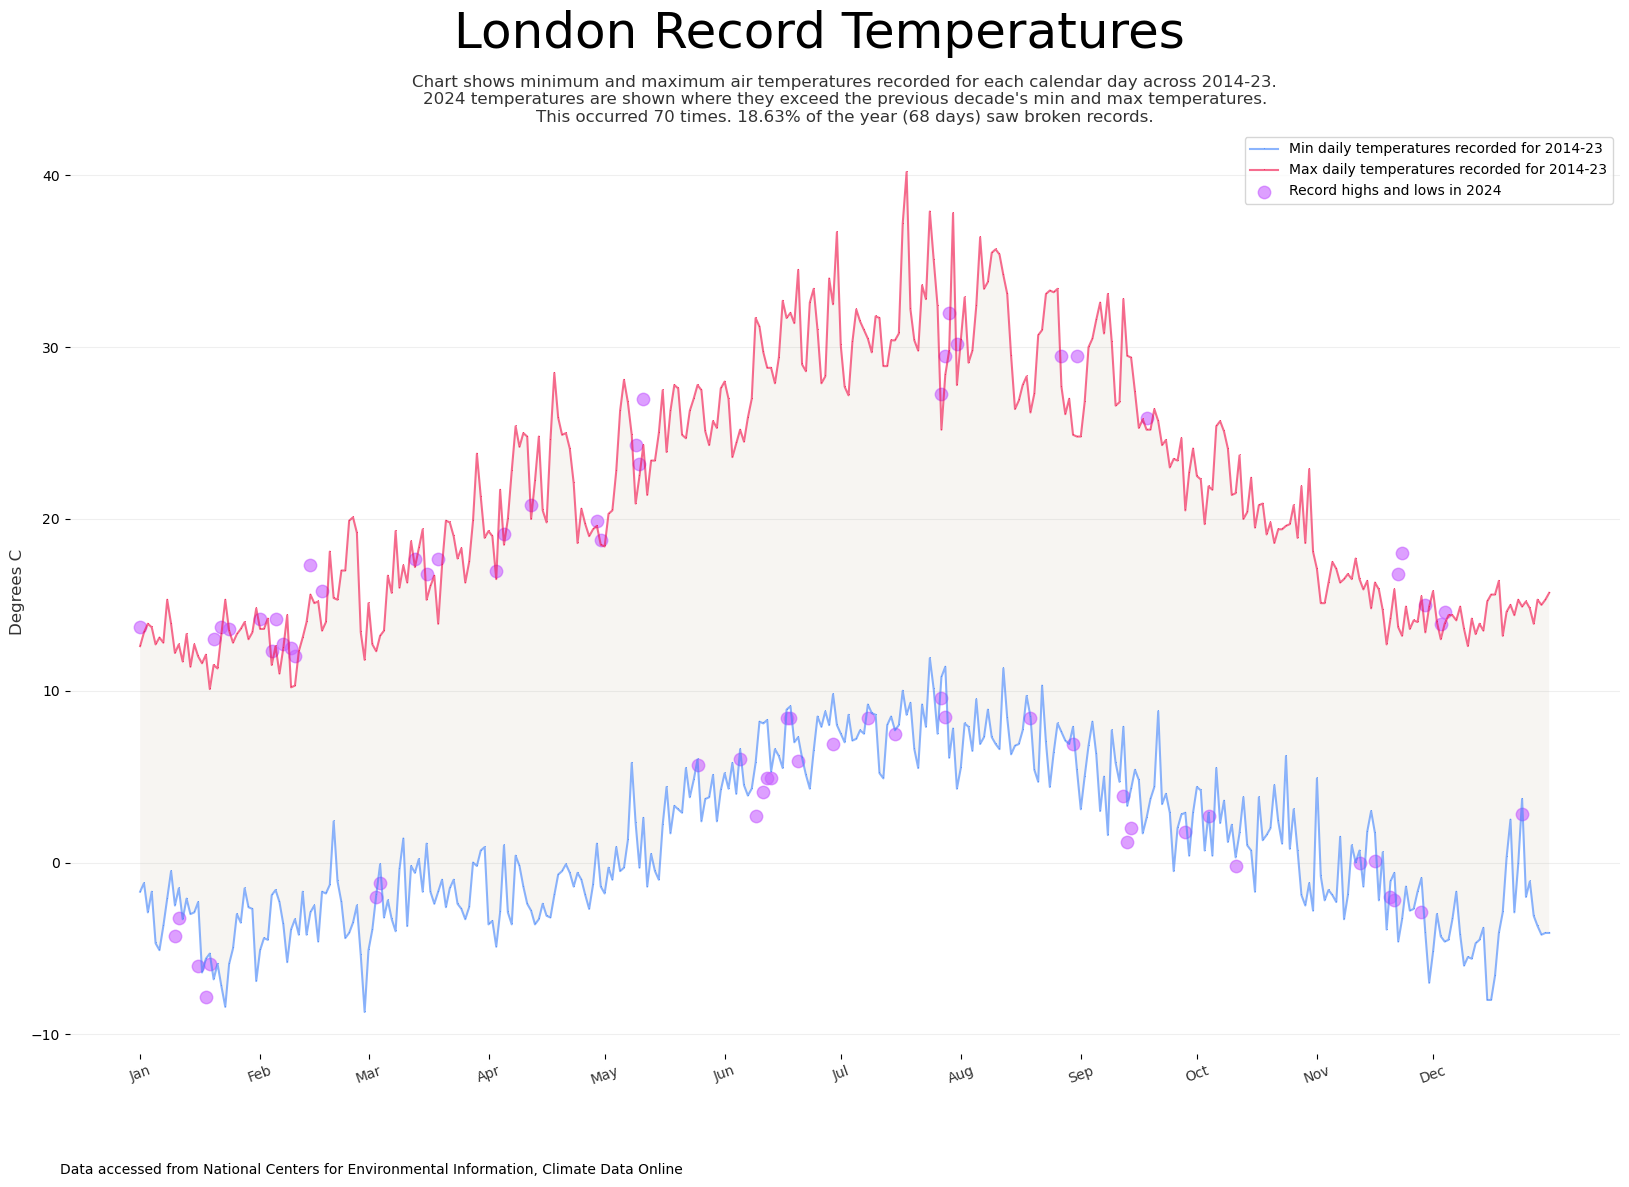

In [21]:
import matplotlib.pyplot as plt
from calendar import month_abbr

plt.figure(figsize=(20, 12))#, facecolor='xkcd:dark grey');

plt.ylabel('Degrees C', alpha=0.8, fontsize=12)
#plt.xlabel('Year from January through December', alpha=0.8)
plt.suptitle('London Record Temperatures', fontsize=36)#, x=0.125, ha='left')
plt.title(f"Chart shows minimum and maximum air temperatures recorded for each calendar day across 2014-23.\n2024 temperatures are shown where they exceed the previous decade's min and max temperatures.\nThis occurred {records.size} times. {records.index.nunique()/365:.2%} of the year ({records.index.nunique()} days) saw broken records.", alpha=0.8, fontsize=12)#, loc='left')

plt.plot(mins_14_23, '-,', color='xkcd:dodger blue', alpha=0.6)
plt.plot(maxs_14_23, '-,', color='xkcd:pinkish red', alpha=0.6)
#plt.plot(avg_lows_14_23, '--', color='xkcd:dodger blue', alpha=0.4)
#plt.plot(avg_highs_14_23, '--', color='xkcd:pinkish red', alpha=0.4)

ticks = pd.DataFrame([i, month_abbr[int(x[:2])]] for i, x in enumerate(mins_14_23.index))
ticks.columns=['index', 'month']
ticks_grouped = ticks.groupby('month').first()
plt.xticks(ticks_grouped['index'], ticks_grouped.index, rotation=20, alpha=0.8)

ax = plt.gca()
#ax.set_facecolor('xkcd:dark grey')
ax.fill_between(range(len(mins_14_23)), 
                       mins_14_23, maxs_14_23, 
                       facecolor='xkcd:mushroom', 
                       alpha=0.1,
                       label='_nolegend_');

plt.scatter(records.index, records, s=80, c='xkcd:bright lavender', marker='o', alpha=0.6)
plt.legend(['Min daily temperatures recorded for 2014-23', 'Max daily temperatures recorded for 2014-23', 'Record highs and lows in 2024'], loc='best')
plt.grid(axis = 'y', alpha=0.2)

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.figtext(0.12, 0.01, "Data accessed from National Centers for Environmental Information, Climate Data Online");
plt.savefig('London record air temperatures.png', bbox_inches='tight')

#### Analysis
Although 2024 appears to have a high number of 'record' temperatures, we can see visually that many of them fell within the gaps between the spikes of the 10-year maxima and minima curves. If there were no significant change, year-on-year, we would expect there to be a $1/11$ probability of any given day's maximum or minimum exceeding those of the previous ten years.

In [23]:
print(f"If the distribution is purely random, the expected annual number of maxima (and of minima) would be {365/11:.3f}.")
print(f"The probability of any given day having a record maximum or minimum would be {(11+10)/121:.3f}, so we could expect around {21*365/121:.0f} days annually.")

If the distribution is purely random, the expected annual number of maxima (and of minima) would be 33.182.
The probability of any given day having a record maximum or minimum would be 0.174, so we could expect around 63 days annually.


We can see that 2024 exceeded these expectations by a small margin: 
- record highs: 35; expected: 33.2
- record lows: 35; expected: 33.2
- number of days with records: 68; expected: 63

How significant is this finding?

## Part 2 - time series analysis
To further the analysis, I now want to explore whether the number of record highs and lows is increasing annually. To do this, I'll bring in data from the preceding decade and use this to calculate the annual number of records across the last decade, comparing each year with the preceding ten years.

In [25]:
# Create separate year and month-day columns to facilitate finding extremes for each year
df['YEAR'] = df.DATE.dt.year
df['MD'] = df['DATE'].dt.strftime('%m-%d')

In [27]:
# Pivot data to create minima and maxima tables with year as index and calendar day as column
all_years_minima = pd.pivot_table(df, values="TMIN", index=["YEAR"], columns=["MD"], aggfunc = ["min"])
all_years_maxima = pd.pivot_table(df, values="TMAX", index=["YEAR"], columns=["MD"], aggfunc = ["max"])
#all_years_minima.head()

In [29]:
# I'll now use rolling windows to calculate the decade extremes
decade_minima = all_years_minima.rolling(window=10).min()
decade_maxima = all_years_maxima.rolling(window=10).max()

In [31]:
# Finally, I'll create a dataframe that gives the number of record minima and maxima for each year vis-a-vis the previous decade
records = [[year, sum(all_years_minima.loc[year] < decade_minima.loc[year-1]), sum(all_years_maxima.loc[year] > decade_maxima.loc[year-1])] for year in range(1985,2025)]
records = pd.DataFrame(records, columns=['YEAR','Record_minima', 'Record_maxima'])
#records.head()

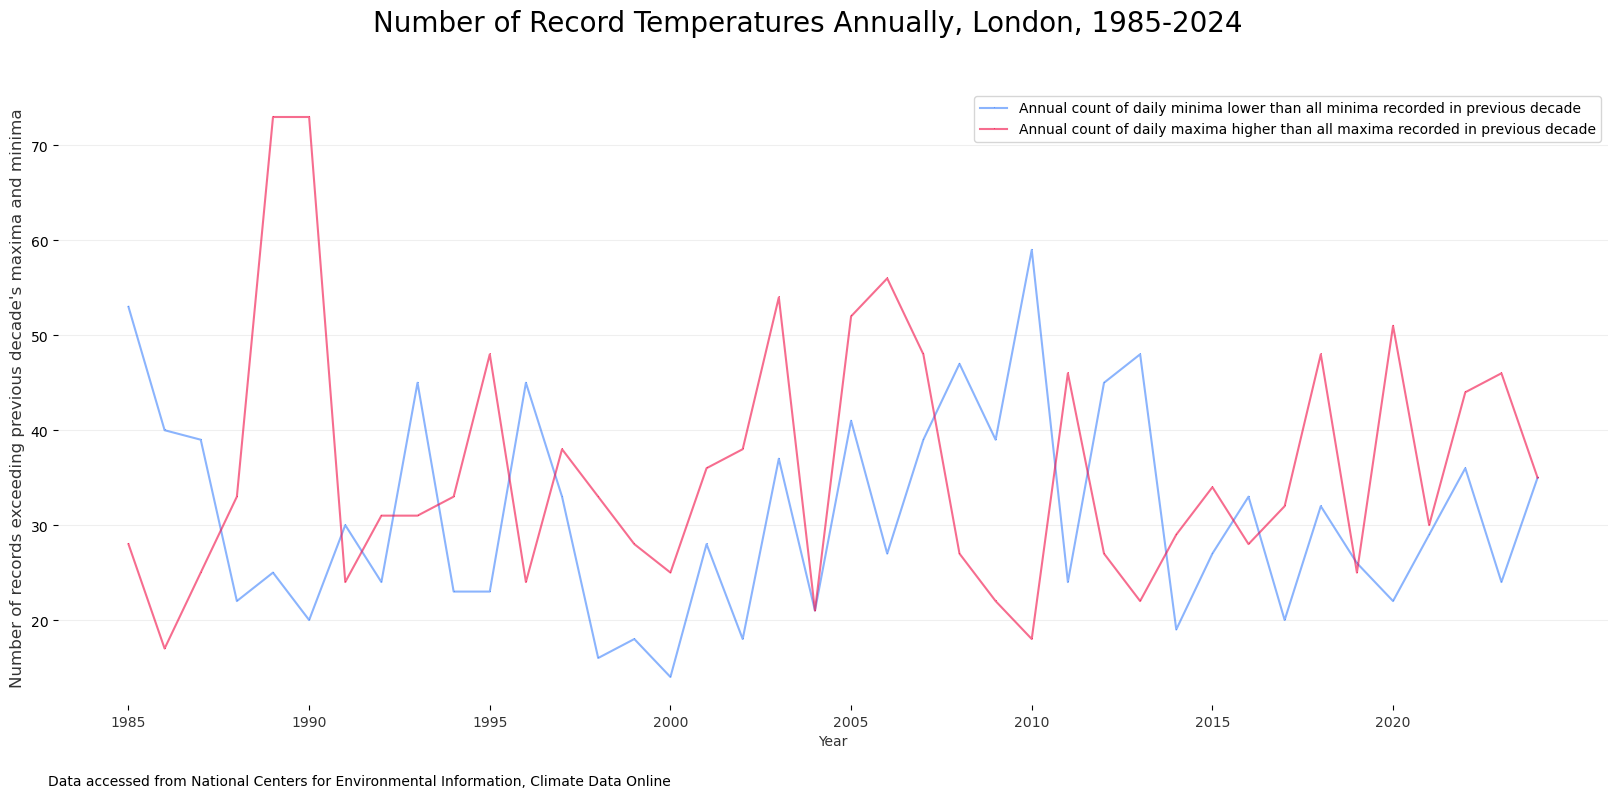

In [33]:
plt.figure(figsize=(20, 8))#, facecolor='xkcd:dark grey');

plt.ylabel("Number of records exceeding previous decade's maxima and minima", alpha=0.8, fontsize=12)
plt.xlabel('Year', alpha=0.8)
plt.suptitle('Number of Record Temperatures Annually, London, 1985-2024', fontsize=20)#, x=0.125, ha='left')
#plt.title(f"Chart shows minimum and maximum air temperatures recorded for each calendar day across 2014-23.\n2024 temperatures are shown where they exceed the previous decade's min and max temperatures.\nThis occurred {records.size} times. A staggering {records.index.nunique()/365:.2%} of the year ({records.index.nunique()} days) saw broken records.", alpha=0.8, fontsize=12)#, loc='left')

plt.plot(records['Record_minima'], '-,', color='xkcd:dodger blue', alpha=0.6)
plt.plot(records['Record_maxima'], '-,', color='xkcd:pinkish red', alpha=0.6)
plt.xticks(records.index[::5], records['YEAR'][::5], alpha=0.8)

#ax = plt.gca()
plt.legend(['Annual count of daily minima lower than all minima recorded in previous decade', 'Annual count of daily maxima higher than all maxima recorded in previous decade'], loc='best')
plt.grid(axis = 'y', alpha=0.2)

# remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.figtext(0.12, 0.01, "Data accessed from National Centers for Environmental Information, Climate Data Online");

There is no immediately apparent trend. I am suprised by the two consecutive years of extremely high numbers of record highs in 1989-90 and have verified that the figures are correct - these were unusually hot years in London.

In [35]:
# The following code block creates a function that can be used to plot the record temperatures for any year vis-a-vis the previous decade
# I used this to examine the two exceptional years of 1989 and 1990
def annual_records_plot(year):
    if year < 1985 or year > 2024:
        raise ValueError("Year must be between 1985 and 2024")
        
    record_lows = all_years_minima.loc[year][all_years_minima.loc[year] < decade_minima.loc[year-1]]
    record_highs = all_years_maxima.loc[year][all_years_maxima.loc[year] > decade_maxima.loc[year-1]]
    r_all = pd.concat([record_lows, record_highs])
    calendar = [d for _, d in all_years_minima.loc[1988].index]

    plt.figure(figsize=(20, 12))
    plt.ylabel('Degrees C', alpha=0.8, fontsize=12)
    plt.suptitle(f'London Record Temperatures - {year}', fontsize=36)
    plt.title(f"Chart shows minimum and maximum air temperatures recorded for each calendar day across {year-11}-{year-1}.\n{year} temperatures are shown where they exceed the previous decade's min and max temperatures.\nThis occurred {r_all.size} times. {len({d for _, d in r_all.index})/365:.2%} of the year ({len({d for _, d in r_all.index})} days) saw broken records.", alpha=0.8, fontsize=12)#, loc='left')
    plt.plot(calendar, decade_minima.loc[year-1], '-,', color='xkcd:dodger blue', alpha=0.6)
    plt.plot(calendar, decade_maxima.loc[year-1], '-,', color='xkcd:pinkish red', alpha=0.6)

    ticks = pd.DataFrame([i, month_abbr[int(x[:2])]] for i, x in enumerate(calendar))
    ticks.columns=['index', 'month']
    ticks_grouped = ticks.groupby('month').first()
    plt.xticks(ticks_grouped['index'], ticks_grouped.index, rotation=20, alpha=0.8)

    ax = plt.gca()
    ax.fill_between(range(len(calendar)), 
                           decade_minima.loc[year-1], decade_maxima.loc[year-1], 
                           facecolor='xkcd:mushroom', alpha=0.1, label='_nolegend_');

    plt.scatter([d for _, d in r_all.index], r_all, s=80, c='xkcd:bright lavender', marker='o', alpha=0.6)
    plt.legend([f'Min daily temperatures recorded for {year-11}-{year-1}', f'Max daily temperatures recorded for {year-11}-{year-1}', f'Record highs and lows in {year}'], loc='best')
    plt.grid(axis = 'y', alpha=0.2)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.figtext(0.12, 0.01, "Data accessed from National Centers for Environmental Information, Climate Data Online");

In [31]:
#annual_records_plot(1990)

#### Deviation from expected mean
To understand the significance of our results for 2024, I'll now delve into the statistical profile of our annual minima and maxima records.

In [37]:
print(f"Expected average annual number of record minima/maxima if variation is purely attributed to randomness: {365/11:.3f}")
print(f"The average annual number of record minima is: {records['Record_minima'].mean()}. Standard deviation is {records['Record_minima'].std():.3f}.")
print(f"The average annual number of record maxima is: {records['Record_maxima'].mean()}. Standard deviation is {records['Record_maxima'].std():.3f}.")

Expected average annual number of record minima/maxima if variation is purely attributed to randomness: 33.182
The average annual number of record minima is: 31.15. Standard deviation is 11.026.
The average annual number of record maxima is: 35.825. Standard deviation is 13.527.


Given the high degree of variation, we cannot be certain that these lower and higher averages are not simply effects of randomness. Calculating the margin of error from the expected mean using a 90% confidence interval, we see that both fall within this error margin.

In [39]:
z = 1.960 # for 95%
z = 1.645 # for 90%
#z = 1.282 # for 80%
s = [11.026, 13.527][1]
n = 40
margin_of_error = z*s/n**0.5
print(f"Lower and upper margins of error: {365/11 - margin_of_error:.2f}, {365/11 + margin_of_error:.2f}")

Lower and upper margins of error: 29.66, 36.70


#### Autocorrelation
We can plot autocorrelation and partial autocorrelation to better understand the make-up of the record maxima and minima curves.

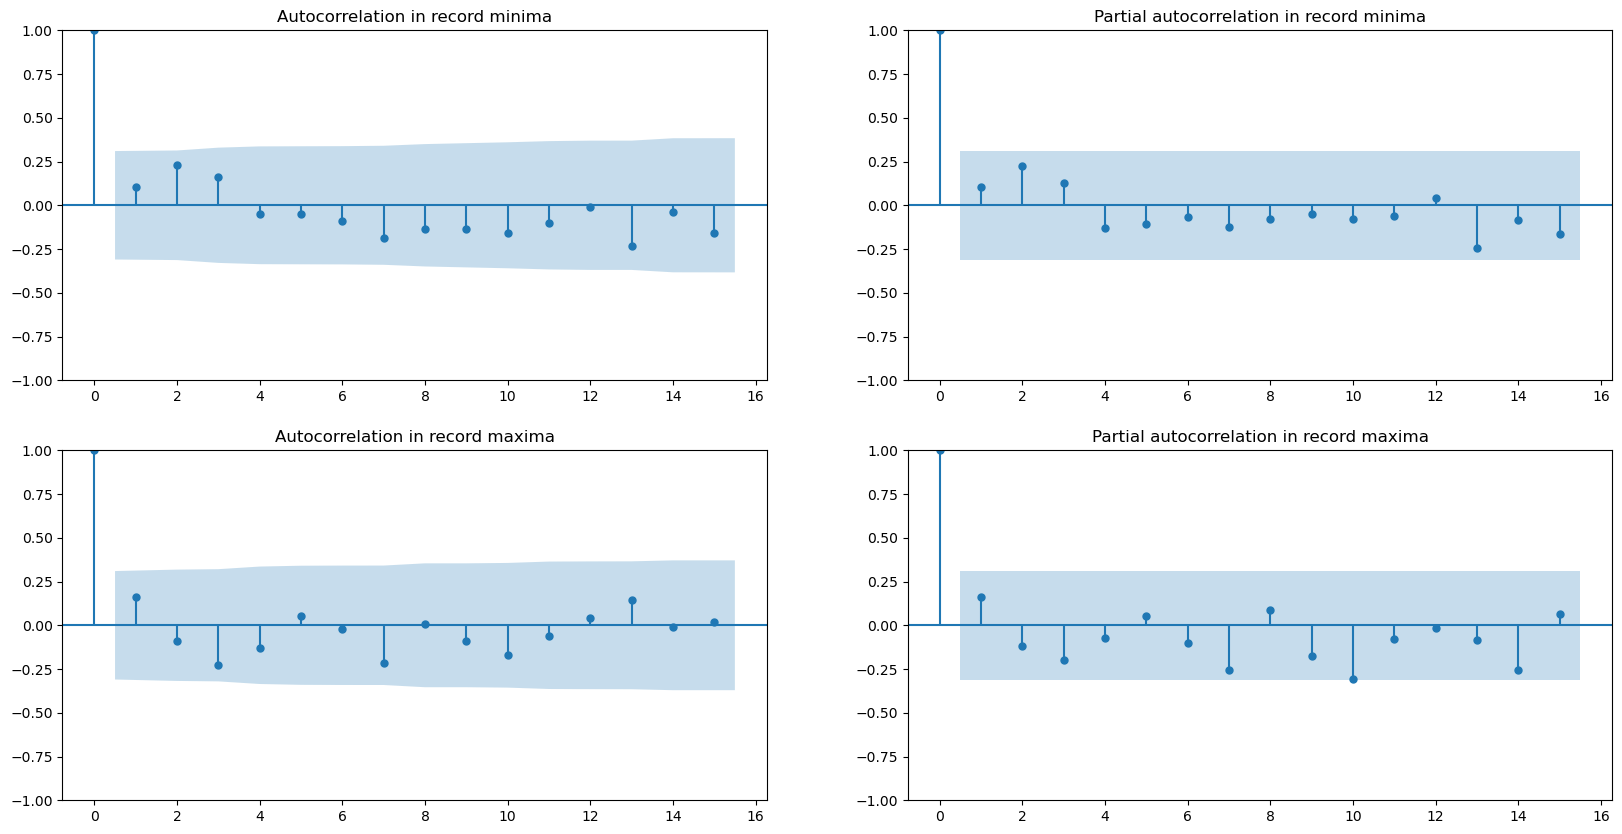

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
fig,axes = plt.subplots(2, 2, figsize=(20, 10),)

fig = plot_acf(records['Record_minima'], lags=15, title='Autocorrelation in record minima', ax = axes[0,0])
fig = plot_pacf(records['Record_minima'], lags=15, title='Partial autocorrelation in record minima', ax = axes[0,1])
fig = plot_acf(records['Record_maxima'], lags=15, title='Autocorrelation in record maxima', ax = axes[1,0])
fig = plot_pacf(records['Record_maxima'], lags=15, title='Partial autocorrelation in record maxima', ax = axes[1,1])


There is no apparent autocorrelation.

#### Monthly record counts

Let's summarise the record count by month, to explore seasonal variation.

In [43]:
all_years_maxima.columns = all_years_maxima.columns.get_level_values(1)
#all_years_minima.columns = all_years_minima.columns.get_level_values(1)
format = '%m-%d'
all_years_maxima.columns = pd.to_datetime(all_years_maxima.columns, format=format)
decade_maxima.columns = all_years_maxima.columns
all_years_minima.columns = all_years_maxima.columns
decade_minima.columns = all_years_maxima.columns

In [45]:
monthly_minima = pd.DataFrame([(all_years_minima.loc[year] < decade_minima.loc[year-1]).resample('ME').sum() for year in range(1985,2025)])
monthly_minima.columns = [x for x in range(1,13)]
#monthly_minima.columns = pd.to_datetime(monthly_minima.columns)
monthly_minima['YEAR'] = [x for x in range(1985, 2025)]
monthly_minima.set_index('YEAR', inplace=True)
#print('Number of record minima per month (vis-a-vis previous decade)')
#display(monthly_minima.head())

monthly_maxima = pd.DataFrame([(all_years_maxima.loc[year] > decade_maxima.loc[year-1]).resample('ME').sum() for year in range(1985,2025)])
monthly_maxima.columns = [x for x in range(1,13)]
#monthly_maxima.columns = pd.to_datetime(monthly_maxima.columns)
monthly_maxima['YEAR'] = [x for x in range(1985, 2025)]
monthly_maxima.set_index('YEAR', inplace=True)
#print('Number of record maxima per month (vis-a-vis previous decade)')
#display(monthly_maxima.head())

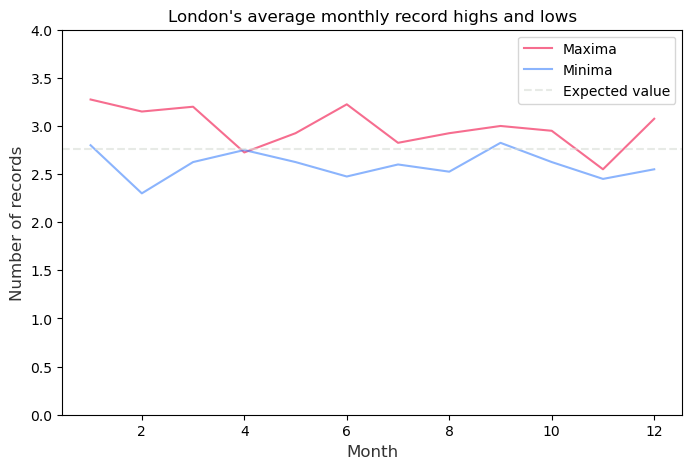

In [47]:
plt.figure(figsize=(8, 5))
plt.ylabel('Number of records', alpha=0.8, fontsize=12)
plt.xlabel('Month', alpha=0.8, fontsize=12)
plt.title(f"London's average monthly record highs and lows", fontsize=12)
plt.plot(monthly_maxima.mean(), color='xkcd:pinkish red', alpha=0.6)
plt.plot(monthly_minima.mean(), color='xkcd:dodger blue', alpha=0.6)
plt.axhline(y=365/11/12, linestyle='--', color='xkcd:light grey', alpha=0.6)
plt.ylim(bottom=0, top=4)
plt.legend(['Maxima', 'Minima', 'Expected value'], loc='best')
plt.show()

#fig = plt.violinplot(monthly_minima, showmeans=True)
#fig = plt.boxplot(monthly_minima, showmeans=True)

Of interest here is that the average monthly maxima counts are typically slightly larger than what we would expect given a purely random distribution, whereas the minima are typically slightly less. Although earlier we weren't able to confirm that the lower average minima and higher average maxima were not the product of random variation, this visualisation suggests they are not.

In [49]:
monthly_minima_mean = monthly_minima.mean().mean()
monthly_minima_mean_std = monthly_minima.mean().std()
monthly_maxima_mean = monthly_maxima.mean().mean()
monthly_maxima_mean_std = monthly_maxima.mean().std()

expected_mean = 365/11/12

z = 2.576 # for 99%
z = 1.960 # for 95%
#z = 1.645 # for 90%
#z = 1.282 # for 80%

n = 12
margin_of_error_minima = z*monthly_minima_mean_std/n**0.5
margin_of_error_maxima = z*monthly_maxima_mean_std/n**0.5

print(f"Expected mean: {expected_mean:.2f}")
print(f"\nMean monthly minima record count: {monthly_minima_mean:.2f}")
print(f"Lower and upper margins of error for mean monthly minima record count: {monthly_minima_mean - margin_of_error_minima:.2f}, {monthly_minima_mean + margin_of_error_minima:.2f}")
print("Includes expected mean? ", expected_mean < monthly_minima_mean + margin_of_error_minima)

print(f"\nMean monthly maxima record count: {monthly_maxima_mean:.2f}")
print(f"Lower and upper margins of error for mean monthly maxima record count: {monthly_maxima_mean - margin_of_error_maxima:.2f}, {monthly_maxima_mean + margin_of_error_maxima:.2f}")
print("Includes expected mean? ", expected_mean > monthly_maxima_mean - margin_of_error_maxima)


Expected mean: 2.77

Mean monthly minima record count: 2.60
Lower and upper margins of error for mean monthly minima record count: 2.51, 2.68
Includes expected mean?  False

Mean monthly maxima record count: 2.99
Lower and upper margins of error for mean monthly maxima record count: 2.86, 3.11
Includes expected mean?  False


We can conclude that the lower and higher means for the record minima and maxima are statistically significant.

It should be noted that these means are calculated using data from across the 40-year dataset. They indicate that the whole dataset shows a tendency toward fewer record minima and more record maxima than we would expect if there were no change to the weather. They do not indicate change across the dataset; they may point to a more long-term trend.

#### Seasonal decomposition and chunking

Decomposition of annual record minima and maxima


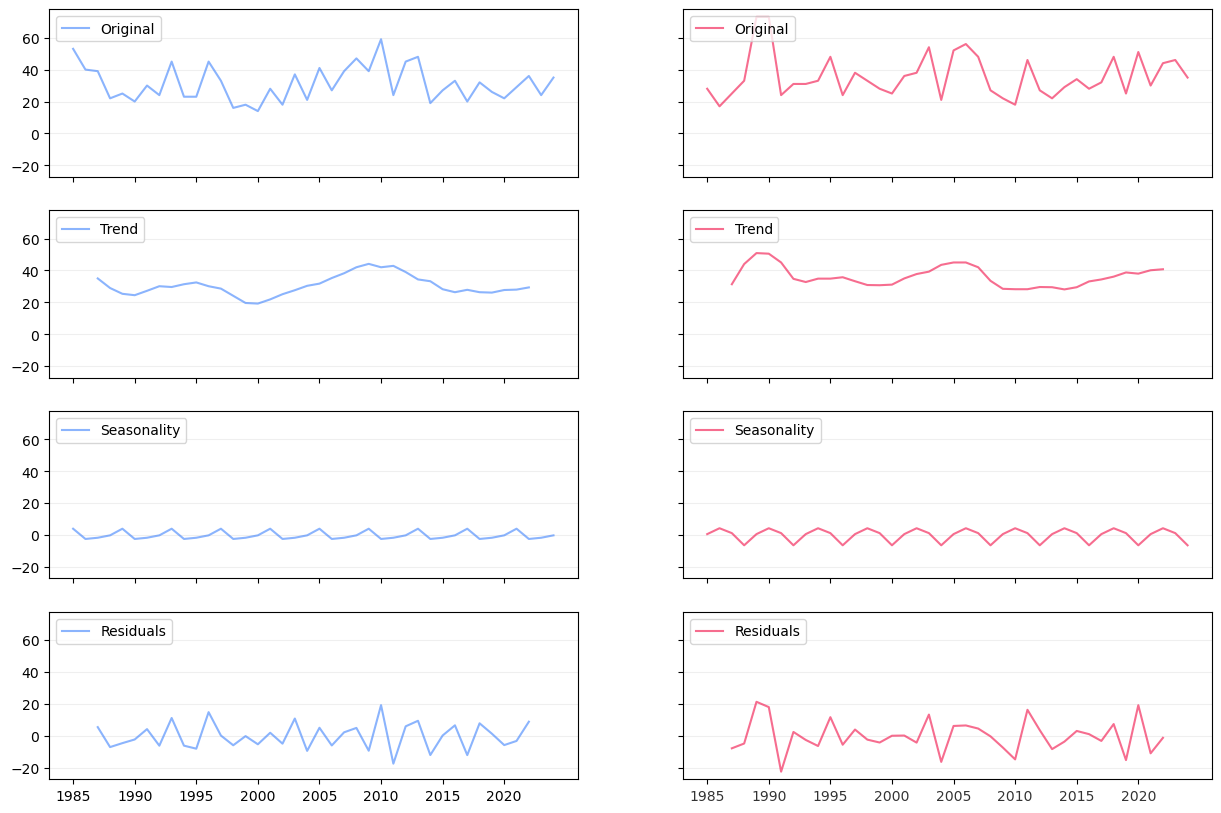

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition_minima = seasonal_decompose(x=records['Record_minima'], model='additive', period=4)
ss_decomposition_maxima = seasonal_decompose(x=records['Record_maxima'], model='additive', period=4)

print("Decomposition of annual record minima and maxima")

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0][0].plot(records['Record_minima'], label='Original', color='xkcd:dodger blue', alpha=0.6)
axes[0][1].plot(records['Record_maxima'], label='Original', color='xkcd:pinkish red', alpha=0.6)

axes[1][0].plot(ss_decomposition_minima.trend, label='Trend', color='xkcd:dodger blue', alpha=0.6)
axes[1][1].plot(ss_decomposition_maxima.trend, label='Trend', color='xkcd:pinkish red', alpha=0.6)

axes[2][0].plot(ss_decomposition_minima.seasonal, label='Seasonality', color='xkcd:dodger blue', alpha=0.6)
axes[2][1].plot(ss_decomposition_maxima.seasonal, label='Seasonality', color='xkcd:pinkish red', alpha=0.6)

axes[3][0].plot(ss_decomposition_minima.resid, label='Residuals', color='xkcd:dodger blue', alpha=0.6)
axes[3][1].plot(ss_decomposition_maxima.resid, label='Residuals', color='xkcd:pinkish red', alpha=0.6)

for r, c in [(r,c) for r in range(4) for c in range(2)]:
    axes[r][c].grid(axis='y', alpha=0.2)
    axes[r][c].legend(loc='upper left');

plt.xticks(records.index[::5], records['YEAR'][::5], alpha=0.8)

plt.show()

The result of seasonal decomposition is highly dependant on the seasonality parameter, but neither curve has clear seasonality. Let's explore how the mean and variance change if we chunk the data.

Gradient of chunked maxima: 0.059
Gradient of chunked minima: 0.000


/Users/huwhallam/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


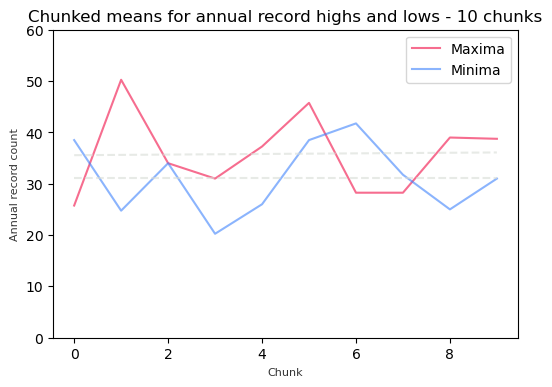

In [53]:
# split data into 10 chunks
chunk_count = 10
chunks_minima = np.split(records['Record_minima'], indices_or_sections=chunk_count)
chunks_maxima = np.split(records['Record_maxima'], indices_or_sections=chunk_count)


plt.figure(figsize=(6, 4))
plt.ylabel('Annual record count', alpha=0.8, fontsize=8)
plt.xlabel('Chunk', alpha=0.8, fontsize=8)
plt.title(f"Chunked means for annual record highs and lows - {chunk_count} chunks", fontsize=12)
plt.plot(np.mean(chunks_maxima,axis=1), color='xkcd:pinkish red', alpha=0.6)
plt.plot(np.mean(chunks_minima,axis=1), color='xkcd:dodger blue', alpha=0.6)

# Calculate the ordinary least squares (OLS) coefficient to determine gradient
y_max = np.matrix(np.mean(chunks_maxima,axis=1)).T
y_min = np.matrix(np.mean(chunks_minima,axis=1)).T
x = np.matrix([[i for i in range(10)], [1]*10]).T
betas_max = ((x.T*x).I*x.T*y_max)
betas_min = ((x.T*x).I*x.T*y_min)

print("Gradient of chunked maxima: {0:.3f}".format(betas_max[0].item()))
plt.plot(range(10), [betas_max[0].item()*x+betas_max[1].item() for x in range(10)], '--', color='xkcd:light grey', alpha=0.6)

print("Gradient of chunked minima: {0:.3f}".format(betas_min[0].item()))
plt.plot(range(10), [betas_min[0].item()*x+betas_min[1].item() for x in range(10)], '--', color='xkcd:light grey', alpha=0.6)

plt.ylim(bottom=0, top=60)
plt.legend(['Maxima', 'Minima'], loc='best')
plt.show()


The chunked plots follow the contours of the seasonal decomposition trend curves. The maxima curve has a slight upward gradient. The minima curve has gradient 0. 

Do we get a similar curve using the monthly aggregates?

Gradient of chunked maxima: -0.000
Gradient of chunked minima: -0.000


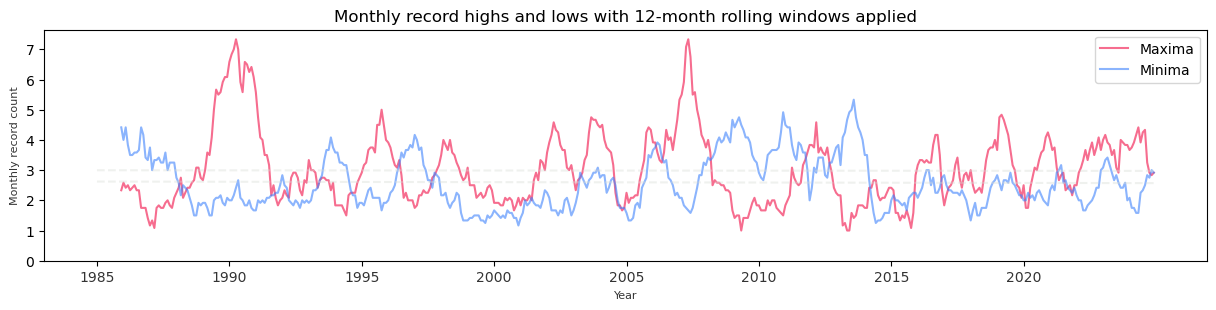

In [55]:
plt.figure(figsize=(15, 3))
plt.ylabel('Monthly record count', alpha=0.8, fontsize=8)
plt.xlabel('Year', alpha=0.8, fontsize=8)
plt.title(f"Monthly record highs and lows with 12-month rolling windows applied", fontsize=12)
plt.plot(list(pd.Series(monthly_maxima.stack()).rolling(window=12).mean()), color='xkcd:pinkish red', alpha=0.6)
plt.plot(list(pd.Series(monthly_minima.stack()).rolling(window=12).mean()), color='xkcd:dodger blue', alpha=0.6)

# Calculate the ordinary least squares (OLS) coefficient to determine gradient
y_max = np.matrix(monthly_maxima.stack()).T
y_min = np.matrix(monthly_minima.stack()).T
x = np.matrix([[i for i in range(40*12)], [1]*40*12]).T
betas_max = ((x.T*x).I*x.T*y_max)
betas_min = ((x.T*x).I*x.T*y_min)

print("Gradient of chunked maxima: {0:.3f}".format(betas_max[0].item()))
plt.plot(range(40*12), [betas_max[0].item()*x+betas_max[1].item() for x in range(40*12)], '--', color='xkcd:light grey', alpha=0.4)

print("Gradient of chunked minima: {0:.3f}".format(betas_min[0].item()))
plt.plot(range(40*12), [betas_min[0].item()*x+betas_min[1].item() for x in range(40*12)], '--', color='xkcd:light grey', alpha=0.4)


plt.ylim(bottom=0)
plt.xticks([i for i in range(0, 40*12, 5*12)], [y for y in range(1985, 2025, 5)], alpha=0.8)
#plt.xticks(records.index[::5*12], records['YEAR'][::5], alpha=0.8)
plt.legend(['Maxima', 'Minima'], loc='best')
plt.show()

The monthly curves bring more complexity to the same basic contours.

Decomposition of monthly record minima and maxima


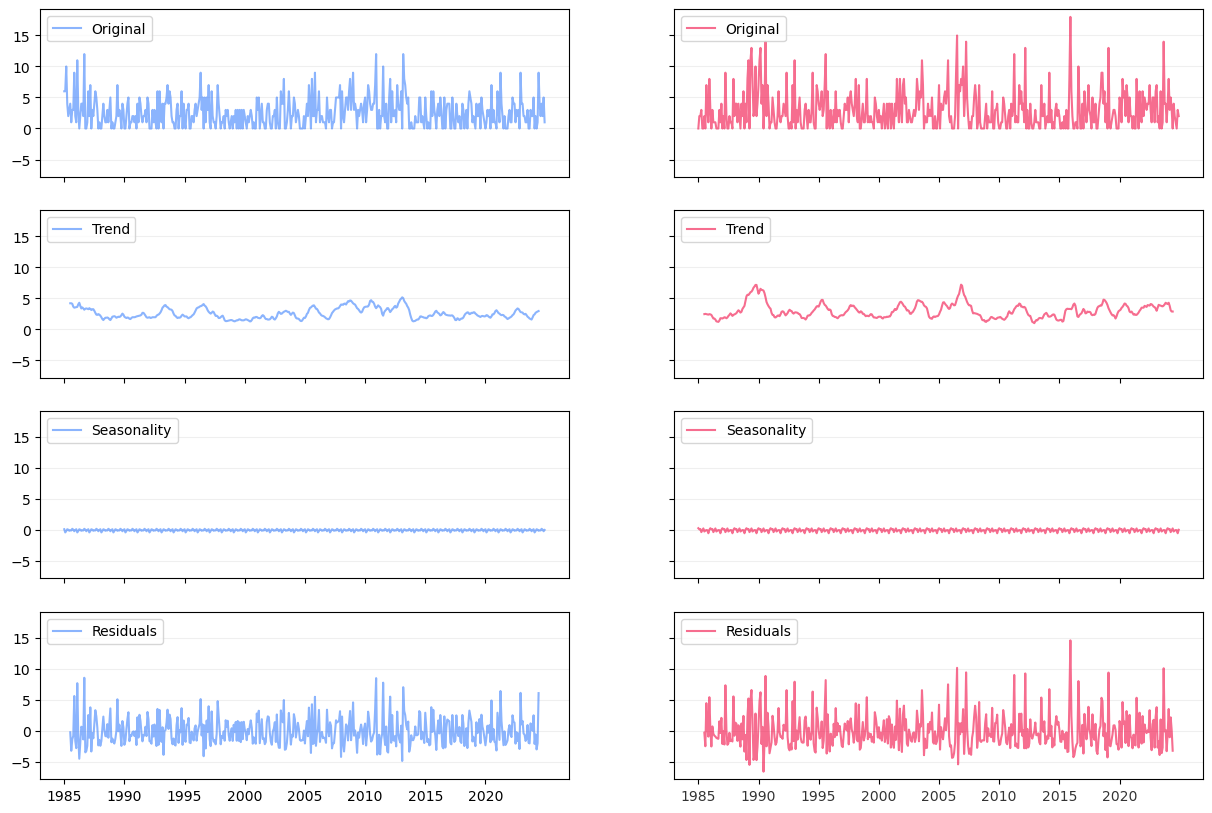

In [57]:
ss_decomposition_monthly_minima = seasonal_decompose(x=list(monthly_minima.stack()), model='additive', period=12)
ss_decomposition_monthly_maxima = seasonal_decompose(x=list(monthly_maxima.stack()), model='additive', period=12)

print("Decomposition of monthly record minima and maxima")

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0][0].plot(list(monthly_minima.stack()), label='Original', color='xkcd:dodger blue', alpha=0.6)
axes[0][1].plot(list(monthly_maxima.stack()), label='Original', color='xkcd:pinkish red', alpha=0.6)
axes[1][0].plot(ss_decomposition_monthly_minima.trend, label='Trend', color='xkcd:dodger blue', alpha=0.6)
axes[1][1].plot(ss_decomposition_monthly_maxima.trend, label='Trend', color='xkcd:pinkish red', alpha=0.6)
axes[2][0].plot(ss_decomposition_monthly_minima.seasonal, label='Seasonality', color='xkcd:dodger blue', alpha=0.6)
axes[2][1].plot(ss_decomposition_monthly_maxima.seasonal, label='Seasonality', color='xkcd:pinkish red', alpha=0.6)
axes[3][0].plot(ss_decomposition_monthly_minima.resid, label='Residuals', color='xkcd:dodger blue', alpha=0.6)
axes[3][1].plot(ss_decomposition_monthly_maxima.resid, label='Residuals', color='xkcd:pinkish red', alpha=0.6)

for r, c in [(r,c) for r in range(4) for c in range(2)]:
    axes[r][c].grid(axis='y', alpha=0.2)
    axes[r][c].legend(loc='upper left');

plt.xticks([i for i in range(0, 40*12, 5*12)], [y for y in range(1985, 2025, 5)], alpha=0.8)

plt.show()

Again we can see similarity between the monthly trend curves and the plot of record highs with windowing applied.

Calculating linear approximations of the trend lines using OLS, we find that the gradients approximate 0.

In [59]:
# Calculate the ordinary least squares (OLS) coefficient to determine gradient
y_max = np.matrix(ss_decomposition_monthly_maxima.trend[6:-6]).T
y_min = np.matrix(ss_decomposition_monthly_minima.trend[6:-6]).T
x = np.matrix([[i for i in range(468)], [1]*468]).T
betas_max = ((x.T*x).I*x.T*y_max)
betas_min = ((x.T*x).I*x.T*y_min)
print(f"Gradient of maxima trend line: {betas_max[0].item()}")
print(f"Gradient of minima trend line: {betas_min[0].item()}")

Gradient of maxima trend line: -0.00014700823091951475
Gradient of minima trend line: 0.0001982531905188432


Let's look at how decomposition performs on the unaggregated dataset.

Decomposition of daily minima and maxima


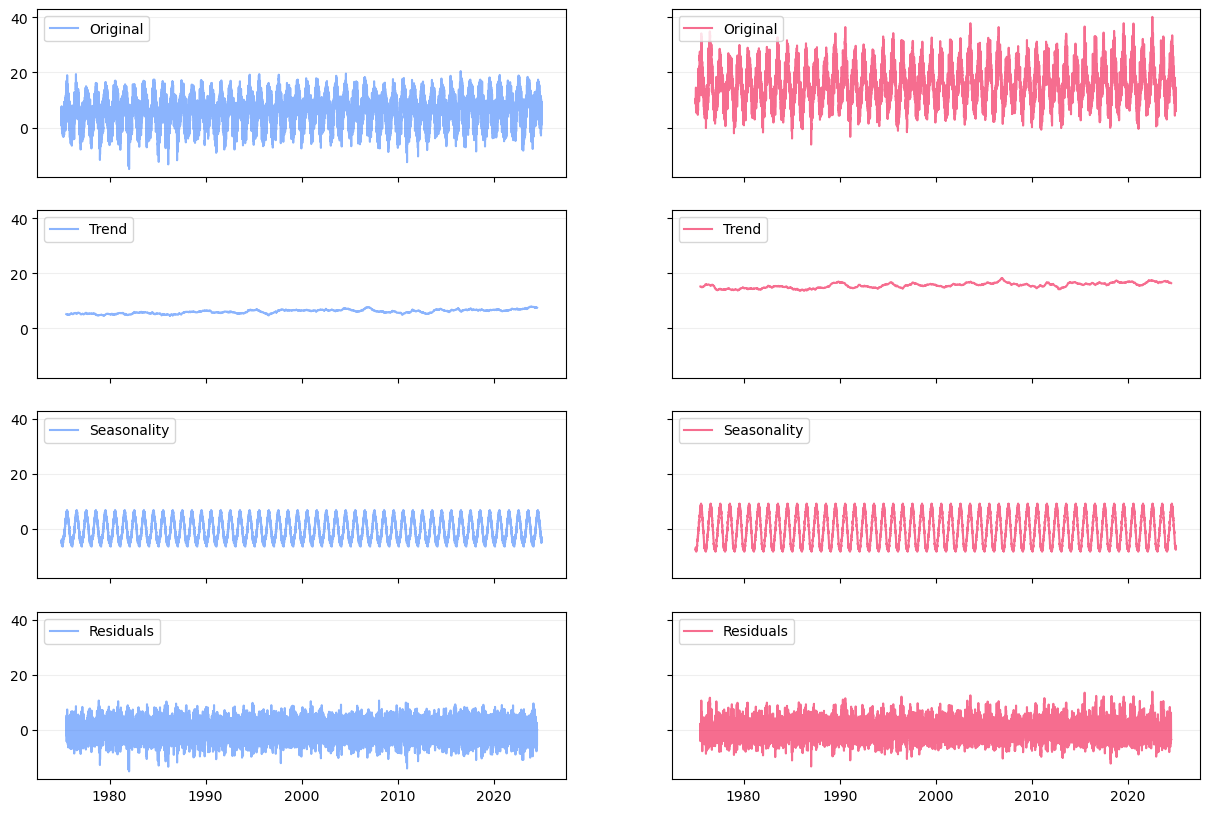

In [61]:
df = df.groupby(['DATE']).agg({'TMIN':'min', 'TMAX':'max'})
df = df.loc[df.index < '2025-01-01']

ss_decomposition_minima = seasonal_decompose(x=df['TMIN'], model='additive', period=365)
ss_decomposition_maxima = seasonal_decompose(x=df['TMAX'], model='additive', period=365)

print("Decomposition of daily minima and maxima")

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0][0].plot(df['TMIN'], label='Original', color='xkcd:dodger blue', alpha=0.6)
axes[0][1].plot(df['TMAX'], label='Original', color='xkcd:pinkish red', alpha=0.6)
axes[1][0].plot(ss_decomposition_minima.trend, label='Trend', color='xkcd:dodger blue', alpha=0.6)
axes[1][1].plot(ss_decomposition_maxima.trend, label='Trend', color='xkcd:pinkish red', alpha=0.6)
axes[2][0].plot(ss_decomposition_minima.seasonal, label='Seasonality', color='xkcd:dodger blue', alpha=0.6)
axes[2][1].plot(ss_decomposition_maxima.seasonal, label='Seasonality', color='xkcd:pinkish red', alpha=0.6)
axes[3][0].plot(ss_decomposition_minima.resid, label='Residuals', color='xkcd:dodger blue', alpha=0.6)
axes[3][1].plot(ss_decomposition_maxima.resid, label='Residuals', color='xkcd:pinkish red', alpha=0.6)

for r, c in [(r,c) for r in range(4) for c in range(2)]:
    axes[r][c].grid(axis='y', alpha=0.2)
    axes[r][c].legend(loc='upper left');

We can again create linear approximations of the trend curves to calculate gradients for the maxima and minima.

In [63]:
# Calculate the ordinary least squares (OLS) coefficient to determine gradient
y_max = np.matrix(ss_decomposition_maxima.trend[182:-182]).T
y_min = np.matrix(ss_decomposition_minima.trend[182:-182]).T
x = np.matrix([[i for i in range(17886)], [1]*17886]).T
betas_max = ((x.T*x).I*x.T*y_max)
betas_min = ((x.T*x).I*x.T*y_min)
print(f"Gradient of maxima trend line : {betas_max[0].item()*365:.3f} (degrees C per year)")
print(f"Gradient of minima trend line: {betas_min[0].item()*365:.3f} (degrees C per year)")

Gradient of maxima trend line : 0.045 (degrees C per year)
Gradient of minima trend line: 0.036 (degrees C per year)


We see that both the minima and maxima are rising at a rate of 1 degree Celsius every 2-3 decades. This is around double the global rate of 0.20C per decade, as calculated by NOAA.

We can check to see whether these trend lines and gradient calculations are supported through a simple 'chunking' of the daily data.

In [65]:
chunk_count = 25
chunks_minima = np.split(df['TMIN'], indices_or_sections=chunk_count)
chunks_maxima = np.split(df['TMAX'], indices_or_sections=chunk_count)

# Calculate the ordinary least squares (OLS) coefficient to determine gradient
y_max = np.matrix(np.mean(chunks_maxima, axis=1)).T
y_min = np.matrix(np.mean(chunks_minima, axis=1)).T
x = np.matrix([[i for i in range(25)], [1]*25]).T

/Users/huwhallam/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


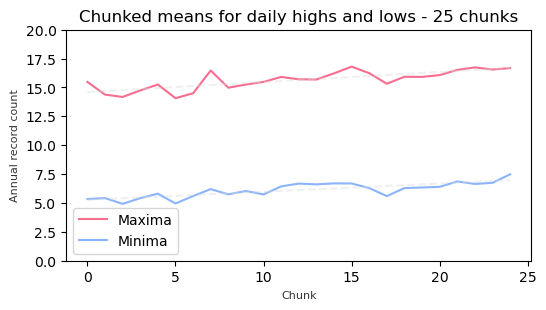

Gradient of maxima trend line: 0.043 (degrees C per year)
Gradient of minima trend line: 0.035 (degrees C per year)


In [67]:
# split data into 10 chunks
chunk_count = 25
chunks_minima = np.split(df['TMIN'], indices_or_sections=chunk_count)
chunks_maxima = np.split(df['TMAX'], indices_or_sections=chunk_count)

# Calculate the ordinary least squares (OLS) coefficient to determine gradient
y_max = np.matrix(np.mean(chunks_maxima, axis=1)).T
y_min = np.matrix(np.mean(chunks_minima, axis=1)).T
x = np.matrix([[i for i in range(25)], [1]*25]).T
betas_max = ((x.T*x).I*x.T*y_max)
betas_min = ((x.T*x).I*x.T*y_min)

plt.figure(figsize=(6, 3))
plt.ylabel('Annual record count', alpha=0.8, fontsize=8)
plt.xlabel('Chunk', alpha=0.8, fontsize=8)
plt.title(f"Chunked means for daily highs and lows - {chunk_count} chunks", fontsize=12)
plt.plot(np.mean(chunks_maxima,axis=1), color='xkcd:pinkish red', alpha=0.6)
plt.plot(np.mean(chunks_minima,axis=1), color='xkcd:dodger blue', alpha=0.6)
plt.plot(range(25), [betas_max[0].item()*x+betas_max[1].item() for x in range(25)], '--', color='xkcd:light grey', alpha=0.4)
plt.plot(range(25), [betas_min[0].item()*x+betas_min[1].item() for x in range(25)], '--', color='xkcd:light grey', alpha=0.4)
plt.ylim(bottom=0, top=20)
plt.legend(['Maxima', 'Minima'], loc='best')
plt.show()

print(f"Gradient of maxima trend line: {betas_max[0].item()/2:.3f} (degrees C per year)")
print(f"Gradient of minima trend line: {betas_min[0].item()/2:.3f} (degrees C per year)")

Chunking the daily data reveals a slight upward trend for both minima and maxima with a very similar estimated gradient. This is consistent with the mean annual record minima and maxima being lower and higher, respectively, than the mean expected through a purely random statistical distribution. There are more record maxima and fewer record minima because both the minimum and maximum teperatures are rising.

#### Augmented Dickey-Fuller Testing for stationarity
In the following section, I use the Augmented Dickey-Fuller test to examine stationarity of the various minima and maxima plots.

In [69]:
# define Dickey-Fuller Test (DFT) function
# Null hypothesis is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries, title, window=12):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='xkcd:dodger blue',label='Original', alpha=0.6)
    mean = plt.plot(rolmean, color='xkcd:pinkish red', label='Rolling Mean', alpha=0.6)
    std = plt.plot(rolstd, color='xkcd:light grey', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{title}: Rolling Mean and Standard Deviation')
    plt.grid(alpha=0.2)
    plt.show(block=False)

Test Statistic         -8.881117e+00
p-value                 1.317156e-14
Lags Used               3.500000e+01
Observations Used       1.821400e+04
Critical Value (1%)    -3.430709e+00
Critical Value (5%)    -2.861699e+00
Critical Value (10%)   -2.566854e+00
dtype: float64


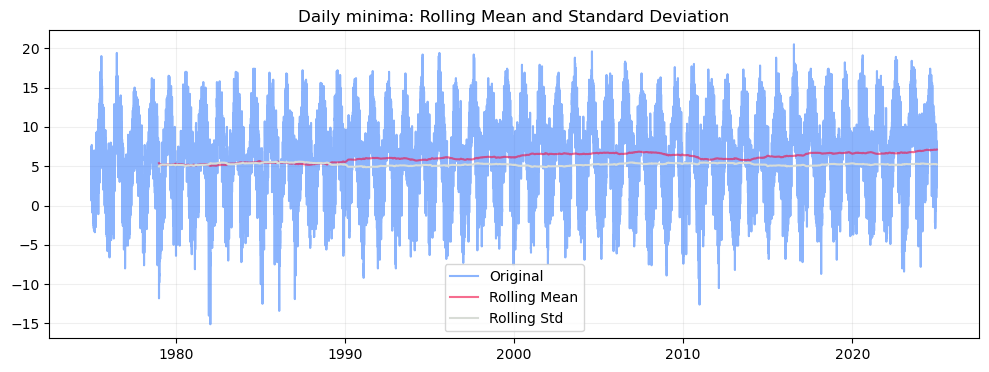

In [71]:
dftest(df['TMIN'], title='Daily minima', window=365*4)

Test Statistic         -9.823959e+00
p-value                 5.247721e-17
Lags Used               4.500000e+01
Observations Used       1.820400e+04
Critical Value (1%)    -3.430709e+00
Critical Value (5%)    -2.861699e+00
Critical Value (10%)   -2.566855e+00
dtype: float64


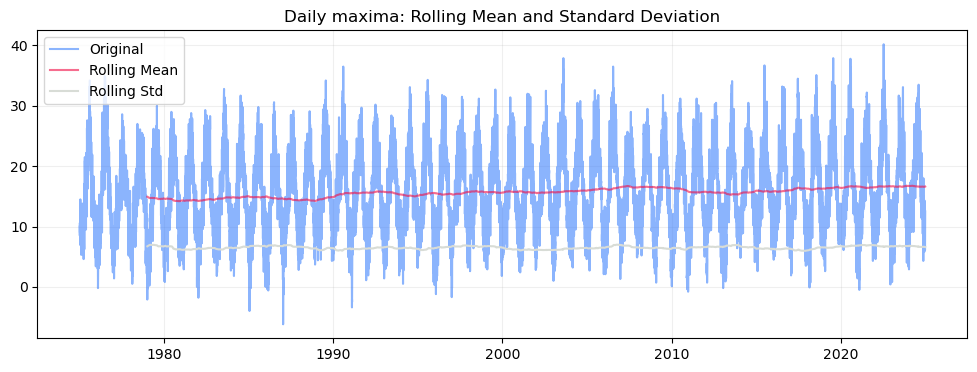

In [73]:
dftest(df['TMAX'], title='Daily maxima', window=365*4)

Test Statistic          -2.671891
p-value                  0.079030
Lags Used                2.000000
Observations Used       37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


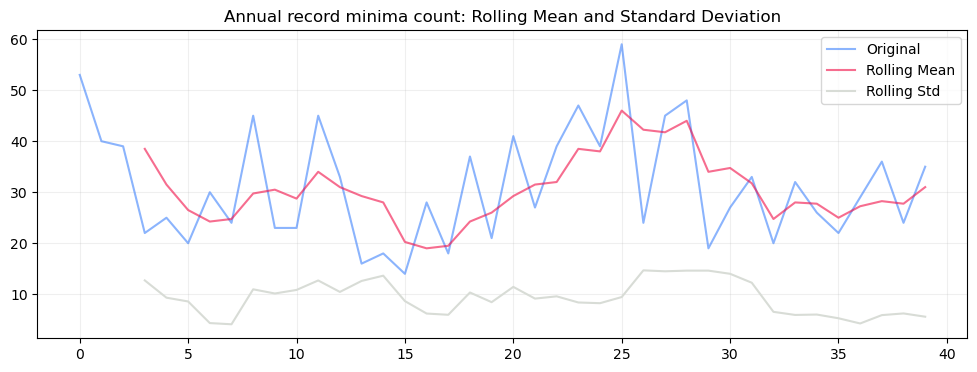

In [75]:
dftest(records['Record_minima'], title='Annual record minima count', window=4)

Test Statistic          -5.178940
p-value                  0.000010
Lags Used                0.000000
Observations Used       39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64


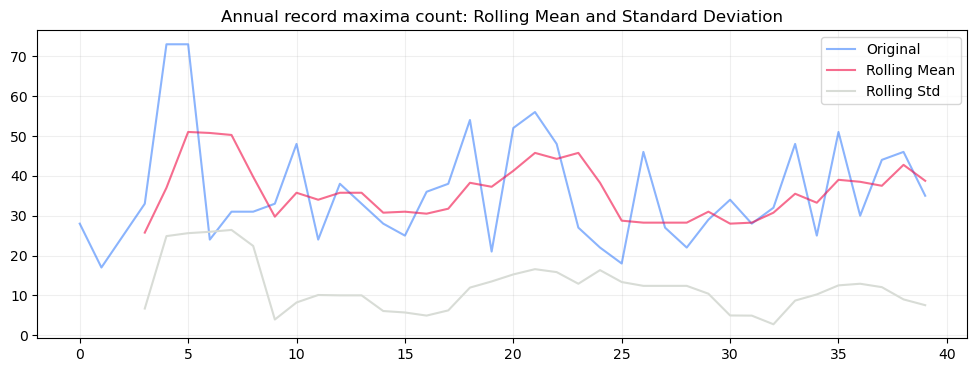

In [77]:
dftest(records['Record_maxima'], title='Annual record maxima count', window=4)

Test Statistic             -2.794023
p-value                     0.059133
Lags Used                  27.000000
Observations Used       17858.000000
Critical Value (1%)        -3.430716
Critical Value (5%)        -2.861702
Critical Value (10%)       -2.566856
dtype: float64


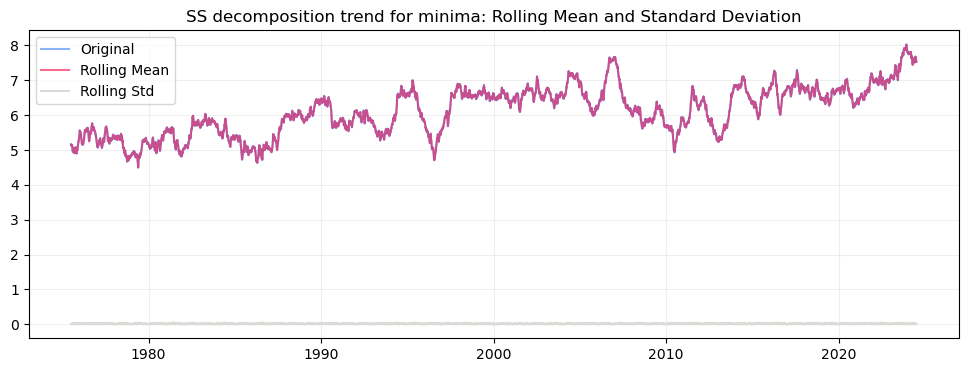

In [79]:
dftest(ss_decomposition_minima.trend.loc[~ss_decomposition_minima.trend.isnull()], title='SS decomposition trend for minima', window=4)

Test Statistic          -1.328682
p-value                  0.615950
Lags Used               10.000000
Observations Used       25.000000
Critical Value (1%)     -3.723863
Critical Value (5%)     -2.986489
Critical Value (10%)    -2.632800
dtype: float64


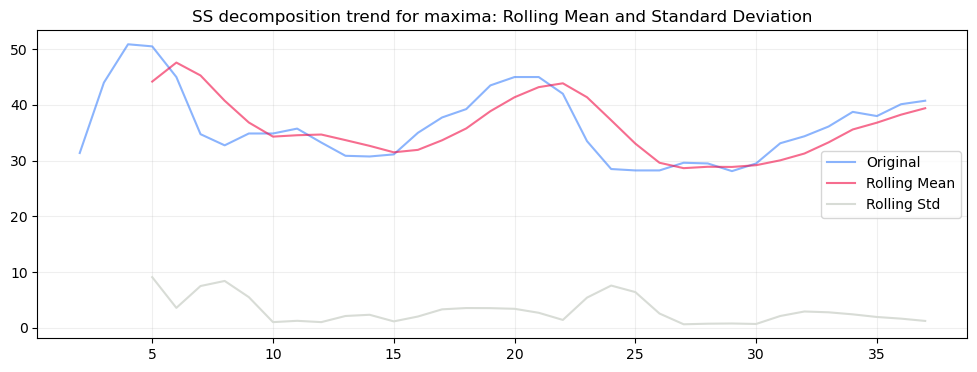

In [235]:
dftest(ss_decomposition_maxima.trend.loc[~ss_decomposition_maxima.trend.isnull()], title='SS decomposition trend for maxima', window=4)

Test Statistic         -1.881779e+01
p-value                 2.022253e-30
Lags Used               0.000000e+00
Observations Used       4.790000e+02
Critical Value (1%)    -3.444076e+00
Critical Value (5%)    -2.867593e+00
Critical Value (10%)   -2.569994e+00
dtype: float64


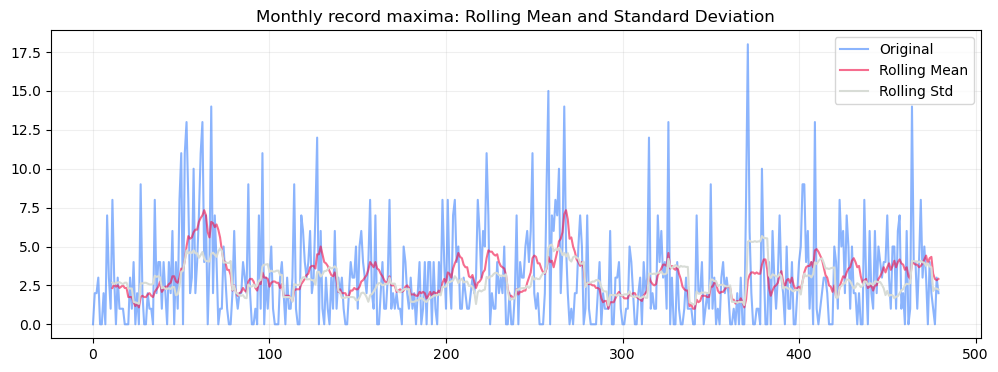

In [81]:
dftest(pd.Series(list(monthly_maxima.stack())), 'Monthly record maxima', window=12)

Test Statistic         -6.692002e+00
p-value                 4.087332e-09
Lags Used               6.000000e+00
Observations Used       4.730000e+02
Critical Value (1%)    -3.444251e+00
Critical Value (5%)    -2.867670e+00
Critical Value (10%)   -2.570035e+00
dtype: float64


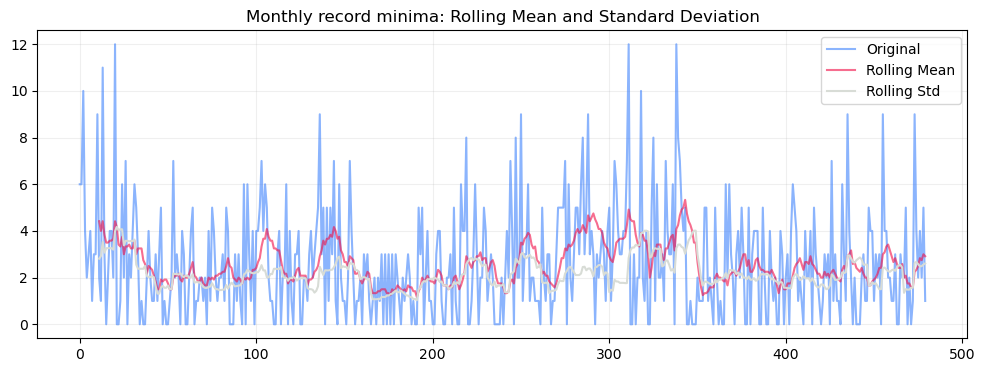

In [83]:
dftest(pd.Series(list(monthly_minima.stack())), 'Monthly record minima', window=12)

#### Summary
Although the DFT indicates stationarity for the daily minima and maxima plots, we have seen through chunking and trend analysis that there is a slight upward trend for both curves and indeed we can see this in the rolling means plotted in red over the original curves. By contrast, the DFT would have us reject the stationarity of the annual record minima plot whereas we found that a lilnear approximation of the curve had a gradient of 0.

We account for this simply by acknowledging the high degree of variation in the data, which easily obscures the very subtle trends. This variation is not accounted for by seasonal change and would require a richer dataset including other variables affecting long-term weather and temperature patterns.

As noted already, we have seen that the number of record highs and lows in London, vis-a-vis those of the preceding decade, are respectively higher and lower than we would expect based on statistical randomness. The number of record highs in 2024 was in line with the 50-year mean; the record lows figure is higher, though well within a standard deviation of the 50-year mean.

Consistent with these figures, we have seen a slight rise in the daily minima and maxima temperatures over the course of the last 50 years. This rise is, concerningly, around double that of the globally calculated warming rate. Further analysis would be needed to understand if and why London's weather is unique in this respect.

## Part 3: Forecasting using deep learning 
#### RNN and LSTM predictions of annual record count
In this section I explore the use of deep learning models to predict future highs and lows.

In [237]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2025-03-26 10:18:54.924633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [416]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_instances, input_instances, test_samples, sample_gap=3):
    """
    Utility processing function that splits a yearly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_instances (int): total instances to extract (may be year or day count)
    input_instances (int): length of sequence taken as training sample for each step; 
                            will also be the size of the component of the test set used to initialise predictions
    test_samples (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 3
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    forecast_series = df[series_name][-series_instances:].values # reducing our forecast series to last n years

    train = forecast_series[:-test_samples] # training data is remaining years until amount of test_samples
    test = forecast_series[-test_samples:] # test data is the remaining test_samples

    train_X, train_y = [], []

    # range 0 through # of train samples - input_instances by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_instances, sample_gap): 
        train_X.append(train[i:i+input_instances]) # each training sample is of length input years
        train_y.append(train[i+input_instances]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_instances] 
    test_y = test[input_instances:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [418]:
def fit_model(train_X, train_y, cell_units, epochs, model_type):
    """
    Fit LSTM or SimpleRNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM/SimpleRNN cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 

    # construct LSTM or SimpleRNN layer with specified number of hidden units per cell and desired sequence input format
    if model_type == 'lstm':
        model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    elif model_type == 'simpleRNN':
        model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    else:
        raise ValueError(f"model must be 'lstm' or 'simpleRNN'. Cannot accept model type '{model_type}") 
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [420]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title, test_samples = 10):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_samples)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

##### Applying SimpleRNN and LSTM to annual record maxima series

In [422]:
train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(records, 'Record_maxima', series_instances = 40, 
                         input_instances = 5, test_samples = 10))

print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (9, 5, 1)
Training output shape: (9,)
Test input shape: (5,)
Test output shape: (5,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


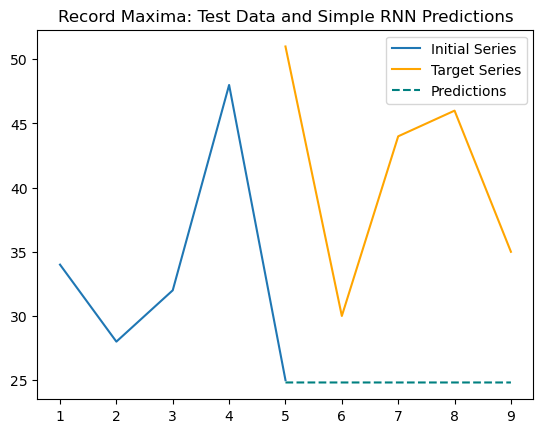

In [424]:
model = fit_model(train_X, train_y, cell_units=32, epochs=756, model_type='simpleRNN')
predict_and_plot(test_X_init, test_y, model,
                 'Record Maxima: Test Data and Simple RNN Predictions')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


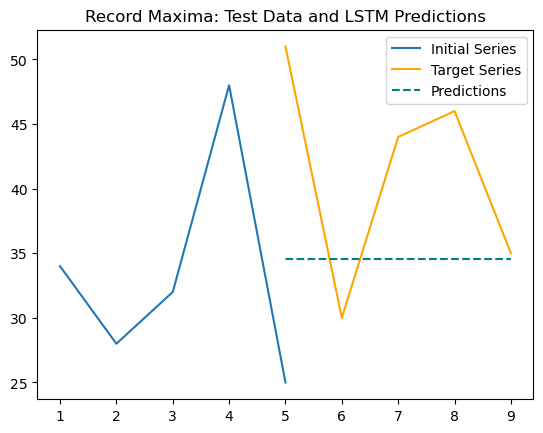

In [426]:
model = fit_model(train_X, train_y, cell_units=32, epochs=756, model_type='lstm')
predict_and_plot(test_X_init, test_y, model,
                 'Record Maxima: Test Data and LSTM Predictions')

##### Applying SimpleRNN and LSTM to annual record minima series

In [431]:
train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(records, 'Record_minima', series_instances = 40, 
                         input_instances = 5, test_samples = 10))

print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (9, 5, 1)
Training output shape: (9,)
Test input shape: (5,)
Test output shape: (5,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


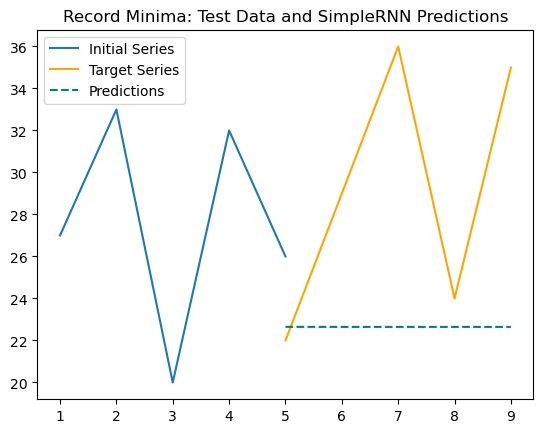

In [437]:
model = fit_model(train_X, train_y, cell_units=32, epochs=756, model_type='simpleRNN')
predict_and_plot(test_X_init, test_y, model,
                 'Record Minima: Test Data and SimpleRNN Predictions')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


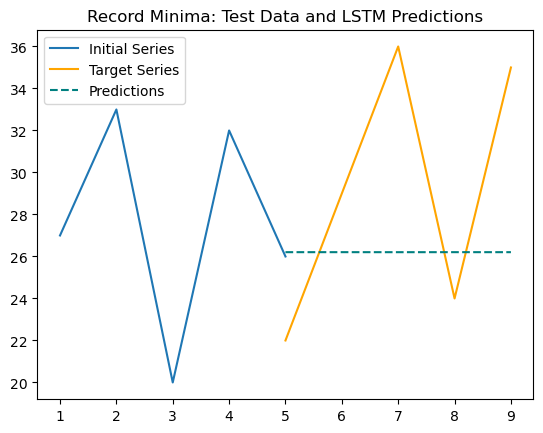

In [435]:
model = fit_model(train_X, train_y, cell_units=32, epochs=756, model_type='lstm')
predict_and_plot(test_X_init, test_y, model,
                 'Record Minima: Test Data and LSTM Predictions')

##### Applying SimpleRNN and LSTM to monthly record minima series

In [888]:
monthly_record_counts = pd.DataFrame({'monthly_maxima': list(monthly_maxima.stack()), 'monthly_minima': list(monthly_maxima.stack())})

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(monthly_record_counts, 'monthly_maxima', series_instances = 480, 
                         input_instances = 12, test_samples = 24))

print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (148, 12, 1)
Training output shape: (148,)
Test input shape: (12,)
Test output shape: (12,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


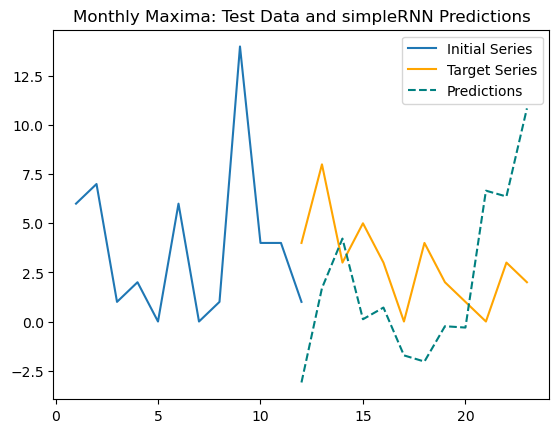

In [892]:
model = fit_model(train_X, train_y, cell_units=32, epochs=756, model_type='simpleRNN')
predict_and_plot(test_X_init, test_y, model,
                 'Monthly Maxima: Test Data and simpleRNN Predictions', test_samples = 24)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


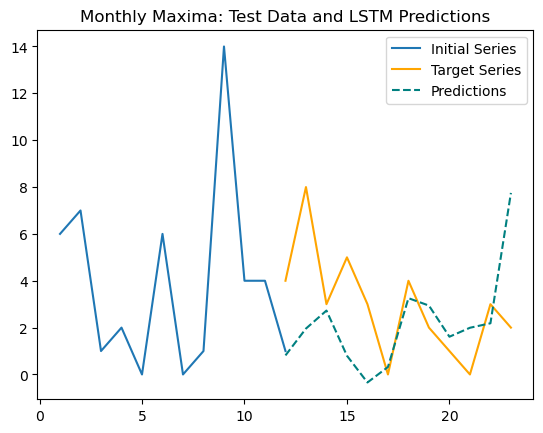

In [894]:
model = fit_model(train_X, train_y, cell_units=32, epochs=756, model_type='lstm')
predict_and_plot(test_X_init, test_y, model,
                 'Monthly Maxima: Test Data and LSTM Predictions', test_samples = 24)

##### Applying Simple RNN and LSTM to daily maxima and minima

In [455]:
train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df, 'TMAX', series_instances = 365*30, 
                         input_instances = 365, test_samples = 365*2))

print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (3285, 365, 1)
Training output shape: (3285,)
Test input shape: (365,)
Test output shape: (365,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

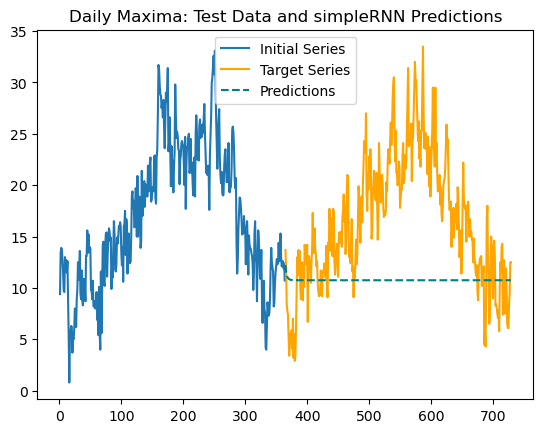

In [459]:
#model = fit_model(train_X, train_y, cell_units=128, epochs=1512, model_type='simpleRNN')
predict_and_plot(test_X_init, test_y, model,
                 'Daily Maxima: Test Data and simpleRNN Predictions', test_samples = 365*2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

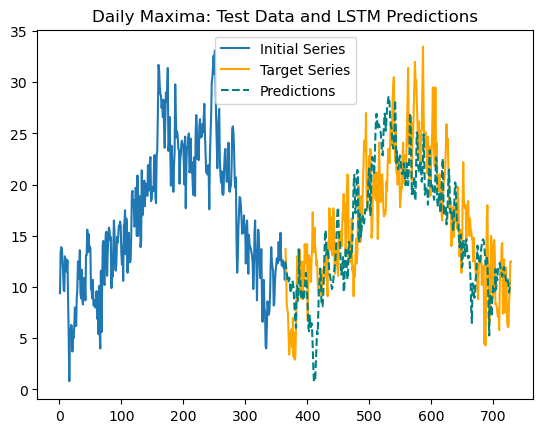

In [461]:
model = fit_model(train_X, train_y, cell_units=64, epochs=756, model_type='lstm')
predict_and_plot(test_X_init, test_y, model,
                 'Daily Maxima: Test Data and LSTM Predictions', test_samples = 365*2)

#### Observations
At this level of tuning, the neural networks are not able to predict on future record temperatures with a useful degree of accuracy (LSTM does slightly better than the simple RNN). Though it may be possible to tune the models further, this is a resource intensive process and it seems unlikely that the neural networks will do a better job of extracting patterns from the noise than the less intensive methods already explored.